In [ ]:
# ------------------------------------------------------------------------------
# Install all necessary packages
# ------------------------------------------------------------------------------

!pip install contextily
!pip install folium
!pip install geopandas
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install scipy
!pip install shapely

In [21]:
# ------------------------------------------------------------------------------
# Import necessary packages
# ------------------------------------------------------------------------------

import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import cluster
import matplotlib.pyplot as plt
import scipy
import contextily
import folium

In [3]:
# ------------------------------------------------------------------------------
# Read and check airbnbs in listings.csv
# ------------------------------------------------------------------------------

csv_file_path = '/content/drive/MyDrive/SDS/Input/listings.csv'

# Read CSV and check columns
airbnb_preview = pd.read_csv(csv_file_path)
airbnb_preview.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

In [4]:
# ------------------------------------------------------------------------------
# Filter listings.csv and load into project
# ------------------------------------------------------------------------------

# Read only selected columns into a data frame
selected_columns = ['id','longitude', 'latitude', 'price', 'number_of_reviews', 'neighbourhood']
airbnb = pd.read_csv(csv_file_path, usecols=selected_columns)

# Display the data
print(airbnb)

# Filter out airbnbs without price and without any reviews
airbnb_filtered = airbnb.dropna(subset =['price'])
airbnb_filtered = airbnb_filtered[airbnb_filtered['number_of_reviews'] > 0]

                        id         neighbourhood   latitude  longitude  price  \
0                    38768          Leopoldstadt  48.219240  16.378310   77.0   
1                    40625  Rudolfsheim-Fnfhaus  48.184340  16.327010  150.0   
2                    51287          Leopoldstadt  48.217780  16.378470   73.0   
3                    70637          Leopoldstadt  48.217600  16.380180   50.0   
4                    75500           Brigittenau  48.234930  16.367520   85.0   
...                    ...                   ...        ...        ...    ...   
14692  1044847812211816491          Leopoldstadt  48.219726  16.411446   81.0   
14693  1045768490651765811             Mariahilf  48.195070  16.340500   44.0   
14694  1045818587935476770              Meidling  48.170751  16.312506  120.0   
14695  1045826740411461383              Meidling  48.170060  16.312240  160.0   
14696  1046241477177647354                Wieden  48.189169  16.375013  104.0   

       number_of_reviews  


In [5]:
# ------------------------------------------------------------------------------
# Assign district numbers to neighbourhoods
# ------------------------------------------------------------------------------

# Get all unique values from column 'neighbourhood'
district_names = airbnb_filtered['neighbourhood'].unique()
district_names

# Write district_names into list and sort list
list_district_names = []
for item in district_names:
  list_district_names.append(item)

list_district_names.sort()
print(list_district_names)
print()

# Create list with district numbers in correct order
list_district_codes = [9, 20, 22, 19, 10, 21, 17, 13, 1, 8, 3, 2, 23, 5, 6, 12, 7, 16, 14, 15, 11, 4, 18]

# Dictionary to link district numbers to district names
district_dict = dict(zip(list_district_names, list_district_codes))
district_dict

# Overwrite column 'neighbourhood' with district number
airbnb_filtered = airbnb_filtered.replace({'neighbourhood': district_dict})

# Cast district number as int
airbnb_filtered['neighbourhood'] = airbnb_filtered['neighbourhood'].astype('int')
airbnb_filtered

['Alsergrund', 'Brigittenau', 'Donaustadt', 'D\x9abling', 'Favoriten', 'Floridsdorf', 'Hernals', 'Hietzing', 'Innere Stadt', 'Josefstadt', 'Landstra§e', 'Leopoldstadt', 'Liesing', 'Margareten', 'Mariahilf', 'Meidling', 'Neubau', 'Ottakring', 'Penzing', 'Rudolfsheim-F\x9fnfhaus', 'Simmering', 'Wieden', 'W\x8ahring']



,id,neighbourhood,latitude,longitude,price,number_of_reviews
0,38768,2,48.219240,16.378310,77.0,384
1,40625,15,48.184340,16.327010,150.0,202
2,51287,2,48.217780,16.378470,73.0,370
3,70637,2,48.217600,16.380180,50.0,116
4,75500,20,48.234930,16.367520,85.0,12
...,...,...,...,...,...,...
14480,1040850168480908475,15,48.191408,16.325239,74.0,1
14525,1039903629641080953,1,48.202190,16.362852,103.0,3
14561,1040423578634668965,5,48.193397,16.356589,117.0,1
14566,1040458038980839907,21,48.247784,16.403738,285.0,1


In [6]:
# ------------------------------------------------------------------------------
# Classify airbnbs in regard to their price
# ------------------------------------------------------------------------------

# Extract the 'price' column as a numpy array
airbnb_price = airbnb_filtered['price'].values

# Calculate the quantiles
q_10 = np.quantile(airbnb_price, 0.1)
q_20 = np.quantile(airbnb_price, 0.2)
q_30 = np.quantile(airbnb_price, 0.3)
q_40 = np.quantile(airbnb_price, 0.4)
q_50 = np.quantile(airbnb_price, 0.5)
q_60 = np.quantile(airbnb_price, 0.6)
q_70 = np.quantile(airbnb_price, 0.7)
q_80 = np.quantile(airbnb_price, 0.8)
q_90 = np.quantile(airbnb_price, 0.9)
q_100 = np.quantile(airbnb_price, 1)

# Write quantile values into list
quantile = [q_10, q_20, q_30, q_40, q_50, q_60, q_70, q_80, q_90, q_100]

# Display the results by looping over the list
for i, q in enumerate(quantile):
    print(f"{(i + 1) * 10}th quantile of 'price': {q}")

10th quantile of 'price': 50.0
20th quantile of 'price': 64.0
30th quantile of 'price': 75.0
40th quantile of 'price': 85.0
50th quantile of 'price': 95.0
60th quantile of 'price': 106.0
70th quantile of 'price': 123.0
80th quantile of 'price': 148.0
90th quantile of 'price': 200.0
100th quantile of 'price': 6000.0


In [7]:
# ------------------------------------------------------------------------------
# Create datasets for each quantile
# ------------------------------------------------------------------------------

# Filter airbnb_filtered according to quantile thresholds
airbnb_q_10 = airbnb_filtered[airbnb_filtered['price'] <= q_10]
airbnb_q_20 = airbnb_filtered[(airbnb_filtered['price'] <= q_20) & (airbnb_filtered['price'] > q_10)]
airbnb_q_30 = airbnb_filtered[(airbnb_filtered['price'] <= q_30) & (airbnb_filtered['price'] > q_20)]
airbnb_q_40 = airbnb_filtered[(airbnb_filtered['price'] <= q_40) & (airbnb_filtered['price'] > q_30)]
airbnb_q_50 = airbnb_filtered[(airbnb_filtered['price'] <= q_50) & (airbnb_filtered['price'] > q_40)]
airbnb_q_60 = airbnb_filtered[(airbnb_filtered['price'] <= q_60) & (airbnb_filtered['price'] > q_50)]
airbnb_q_70 = airbnb_filtered[(airbnb_filtered['price'] <= q_70) & (airbnb_filtered['price'] > q_60)]
airbnb_q_80 = airbnb_filtered[(airbnb_filtered['price'] <= q_80) & (airbnb_filtered['price'] > q_70)]
airbnb_q_90 = airbnb_filtered[(airbnb_filtered['price'] <= q_90) & (airbnb_filtered['price'] > q_80)]
airbnb_q_100 = airbnb_filtered[airbnb_filtered['price'] > q_90]

In [8]:
# ------------------------------------------------------------------------------
# Calculate number of airbnbs per neighbourhood
# ------------------------------------------------------------------------------

# Create empty data frame with one column 'neighbourhood'
count_per_nb = pd.DataFrame({'neighbourhood' : []})

# Get neighbourhoods from airbnb_q_10
nbh_numbers = airbnb_q_10.groupby('neighbourhood').size().reset_index()
count_per_nb['neighbourhood'] = nbh_numbers['neighbourhood']

# Write quantile datasets into a list for looping
datasets = [airbnb_q_10, airbnb_q_20, airbnb_q_30, airbnb_q_40, airbnb_q_50, airbnb_q_60, airbnb_q_70, airbnb_q_80, airbnb_q_90, airbnb_q_100]

# Loop over the datasets to count the number of airbnbs per quantile per district
for i in range(len(datasets)):
    quantile_extract = f'q_{(i+1)*10}_counts'
    column_name = f'count_q_{(i+1)*10}'
    globals()[quantile_extract] = datasets[i].groupby('neighbourhood').size().reset_index(name=column_name)
    count_per_nb[column_name] = globals()[quantile_extract][column_name]

# Keel all columns except for 'neighbourhood'
count_per_nb_filtered = count_per_nb.loc[:, count_per_nb.columns != 'neighbourhood']

In [9]:
# ------------------------------------------------------------------------------
# Calculate the percentual share of each quantile count per district
# ------------------------------------------------------------------------------

# Create a list of column names from count_per_nb_filtered for looping
count_columns = ['count_q_10', 'count_q_20', 'count_q_30', 'count_q_40', 'count_q_50', 'count_q_60', 'count_q_70', 'count_q_80', 'count_q_90', 'count_q_100']

# Calculate the percentage for each count column for each row
for column in count_columns:
    percentage_column_name = column + '_percentage'
    count_per_nb_filtered[percentage_column_name] = (count_per_nb_filtered[column] / count_per_nb_filtered[count_columns].sum(axis=1)) * 100

# Display the resulting data frame
count_per_nb_filtered

,count_q_10,count_q_20,count_q_30,count_q_40,count_q_50,count_q_60,count_q_70,count_q_80,count_q_90,count_q_100,count_q_10_percentage,count_q_20_percentage,count_q_30_percentage,count_q_40_percentage,count_q_50_percentage,count_q_60_percentage,count_q_70_percentage,count_q_80_percentage,count_q_90_percentage,count_q_100_percentage
0,12,6,8,13,9,23,39,52,114,197,2.536998,1.268499,1.691332,2.748414,1.902748,4.862579,8.245243,10.993658,24.101480,41.649049
1,114,108,122,109,119,105,121,132,98,105,10.061783,9.532215,10.767873,9.620477,10.503089,9.267432,10.679612,11.650485,8.649603,9.267432
2,67,67,86,87,86,90,85,105,121,114,7.378855,7.378855,9.471366,9.581498,9.471366,9.911894,9.361233,11.563877,13.325991,12.555066
3,26,26,37,19,31,32,33,44,45,55,7.471264,7.471264,10.632184,5.459770,8.908046,9.195402,9.482759,12.643678,12.931034,15.804598
4,63,62,70,54,53,56,61,66,48,31,11.170213,10.992908,12.411348,9.574468,9.397163,9.929078,10.815603,11.702128,8.510638,5.496454
5,20,22,26,26,35,35,54,45,51,68,5.235602,5.759162,6.806283,6.806283,9.162304,9.162304,14.136126,11.780105,13.350785,17.801047
6,23,33,35,44,47,52,51,61,38,63,5.145414,7.382550,7.829978,9.843400,10.514541,11.633110,11.409396,13.646532,8.501119,14.093960
7,19,10,22,26,26,14,24,18,32,36,8.370044,4.405286,9.691630,11.453744,11.453744,6.167401,10.572687,7.929515,14.096916,15.859031
8,33,37,63,64,33,42,58,47,58,38,6.976744,7.822410,13.319239,13.530655,6.976744,8.879493,12.262156,9.936575,12.262156,8.033827
9,95,94,108,86,123,91,100,85,63,46,10.662177,10.549944,12.121212,9.652076,13.804714,10.213244,11.223345,9.539843,7.070707,5.162738


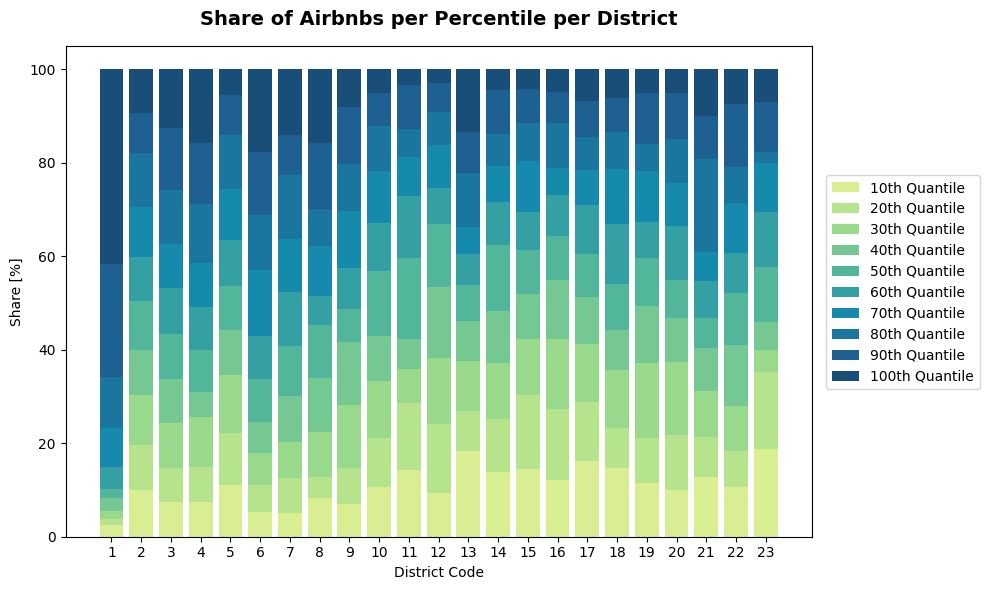

In [10]:
# ------------------------------------------------------------------------------
# Create stacked bar plot
# ------------------------------------------------------------------------------

# List with district codes for x axis labels
x = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

# Write percentage values into a list per quantiles
count_q_10 = np.array(count_per_nb_filtered.count_q_10_percentage.tolist())
count_q_20 = np.array(count_per_nb_filtered.count_q_20_percentage.tolist())
count_q_30 = np.array(count_per_nb_filtered.count_q_30_percentage.tolist())
count_q_40 = np.array(count_per_nb_filtered.count_q_40_percentage.tolist())
count_q_50 = np.array(count_per_nb_filtered.count_q_50_percentage.tolist())
count_q_60 = np.array(count_per_nb_filtered.count_q_60_percentage.tolist())
count_q_70 = np.array(count_per_nb_filtered.count_q_70_percentage.tolist())
count_q_80 = np.array(count_per_nb_filtered.count_q_80_percentage.tolist())
count_q_90 = np.array(count_per_nb_filtered.count_q_90_percentage.tolist())
count_q_100 = np.array(count_per_nb_filtered.count_q_100_percentage.tolist())

# Set figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars in stack manner
plt.bar(x, count_q_10, color='#d9ed92')
plt.bar(x, count_q_20, bottom=count_q_10, color='#b5e48c')
plt.bar(x, count_q_30, bottom=count_q_10+count_q_20, color='#99d98c')
plt.bar(x, count_q_40, bottom=count_q_10+count_q_20+count_q_30, color='#76c893')
plt.bar(x, count_q_50, bottom=count_q_10+count_q_20+count_q_30+count_q_40, color='#52b69a')
plt.bar(x, count_q_60, bottom=count_q_10+count_q_20+count_q_30+count_q_40+count_q_50, color='#34a0a4')
plt.bar(x, count_q_70, bottom=count_q_10+count_q_20+count_q_30+count_q_40+count_q_50+count_q_60, color='#168aad')
plt.bar(x, count_q_80, bottom=count_q_10+count_q_20+count_q_30+count_q_40+count_q_50+count_q_60+count_q_70, color='#1a759f')
plt.bar(x, count_q_90, bottom=count_q_10+count_q_20+count_q_30+count_q_40+count_q_50+count_q_60+count_q_70+count_q_80, color='#1e6091')
plt.bar(x, count_q_100, bottom=count_q_10+count_q_20+count_q_30+count_q_40+count_q_50+count_q_60+count_q_70+count_q_80+count_q_90, color='#184e77')

# Set labels
plt.xlabel("District Code")
plt.ylabel("Share [%]")

# Move the legend outside the plot
plt.legend(["10th Quantile", "20th Quantile", "30th Quantile", "40th Quantile", "50th Quantile", "60th Quantile", "70th Quantile", "80th Quantile", "90th Quantile", "100th Quantile"],
           bbox_to_anchor=(1.01, 0.75), loc='upper left')

# Set title
plt.title("Share of Airbnbs per Percentile per District", fontsize = 14, fontweight = 'bold', pad = 15)

# Plot
plt.tight_layout()
plt.show()


In [11]:
# ------------------------------------------------------------------------------
# Convert quantile datasets into GeoJSON
# ------------------------------------------------------------------------------

# Write datasets into list for looping
categories = [airbnb_q_10, airbnb_q_20, airbnb_q_30, airbnb_q_40, airbnb_q_50, airbnb_q_60, airbnb_q_70, airbnb_q_80, airbnb_q_90, airbnb_q_100]

# Write output dataset names into list for looping
output = ["airbnb_q_10", "airbnb_q_20", "airbnb_q_30", "airbnb_q_40", "airbnb_q_50", "airbnb_q_60", "airbnb_q_70", "airbnb_q_80", "airbnb_q_90", "airbnb_q_100"]

# Loop through the categories and convert each data frame to GeoJSON
for i, quantile in enumerate(categories):

    geojson_path = f'/content/drive/MyDrive/SDS/Output/{output[i]}.geojson'

    # Convert data frame to geo data frame
    gdf = gpd.GeoDataFrame(quantile, geometry=gpd.points_from_xy(quantile.longitude, quantile.latitude))

    # Set crs and reproject
    gdf = gdf.set_crs('epsg:4326')
    gdf = gdf.to_crs({'init':'epsg:32633'})

    # Save geo data frame to GeoJSON
    gdf.to_file(geojson_path, driver="GeoJSON")

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of 

In [12]:
# ------------------------------------------------------------------------------
# Read GeoJSON with district boundaries
# ------------------------------------------------------------------------------

districts = gpd.read_file('/content/drive/MyDrive/SDS/Input/bezirksgrenzen.geojson')
print(districts.columns)
print()

# Filter columns
selected_columns_districts = ['NAMEK','BEZNR', 'geometry']
districts_filtered = districts[selected_columns_districts]

# Check data types of columns
districts_filtered.dtypes

# Change column 'BEZNR' from float to int
districts_filtered['BEZNR'] = districts_filtered['BEZNR'].astype('int')

# Project to EPSG 32633 (for analysis + plot) and to EPSG 4326 (for folium map)
print(districts_filtered.crs) # --> EPSG 31256
districts_proj_32633 = districts_filtered.to_crs({'init':'epsg:32633'})
districts_proj_4326 = districts_filtered.to_crs({'init':'epsg:4326'})

Index(['NAMEK', 'BEZNR', 'BEZ_RZ', 'NAMEK_NUM', 'NAMEK_RZ', 'NAMEG', 'LABEL',
       'BEZ', 'DISTRICT_CODE', 'STATAUSTRIA_BEZ_CODE', 'STATAUSTRIA_GEM_CODE',
       'FLAECHE', 'UMFANG', 'AKT_TIMESTAMP', 'SE_SDO_ROWID',
       'SE_ANNO_CAD_DATA', 'geometry'],
      dtype='object')

EPSG:31256


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [13]:
# ------------------------------------------------------------------------------
# Read GeoJSON for quantiles 10, 50, 100
# ------------------------------------------------------------------------------

q_10_gdf = gpd.read_file('/content/drive/MyDrive/SDS/Output/airbnb_q_10.geojson')
q_50_gdf = gpd.read_file('/content/drive/MyDrive/SDS/Output/airbnb_q_50.geojson')
q_100_gdf = gpd.read_file('/content/drive/MyDrive/SDS/Output/airbnb_q_100.geojson')

# Transform 'geometry' column into separate 'x' and 'y' columns
q_10_gdf['x'] = q_10_gdf['geometry'].x
q_10_gdf['y'] = q_10_gdf['geometry'].y

q_50_gdf['x'] = q_50_gdf['geometry'].x
q_50_gdf['y'] = q_50_gdf['geometry'].y

q_100_gdf['x'] = q_100_gdf['geometry'].x
q_100_gdf['y'] = q_100_gdf['geometry'].y

In [14]:
# ------------------------------------------------------------------------------
# DBSCAN clustering
# ------------------------------------------------------------------------------

# Extract x/y columns from quantile datasets
airbnb_q_10_sel = q_10_gdf[['y', 'x']]

airbnb_q_50_sel = q_50_gdf[['y', 'x']]

airbnb_q_100_sel = q_100_gdf[['y', 'x']]

# Check if extraction worked
airbnb_q_100_sel.head()

,y,x
0,5.341997e+06,597847.143262
1,5.341997e+06,597847.143262
2,5.340037e+06,601689.610617
3,5.340027e+06,600631.470516
4,5.339339e+06,601545.942075


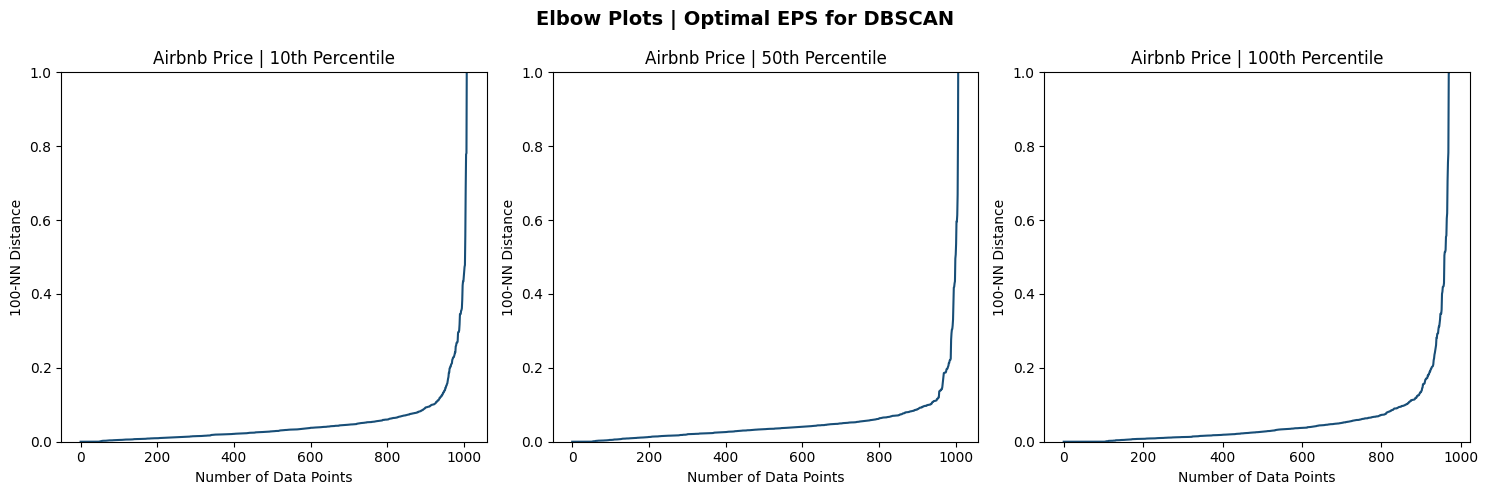

In [19]:
# ------------------------------------------------------------------------------
# Elbow Plot to identify eps value
# ------------------------------------------------------------------------------

# Create list with datasets for looping
dataframes = [airbnb_q_10_sel, airbnb_q_50_sel, airbnb_q_100_sel]

# Create list with titles for subplots
title = ['Airbnb Price | 10th Percentile','Airbnb Price | 50th Percentile','Airbnb Price | 100th Percentile']

# Create 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Loop to fill plots with data
for i, df in enumerate(dataframes):

    # Standardize the data (removing the mean and scaling to unit variance)
    st = sklearn.preprocessing.StandardScaler()
    stdDf = pd.DataFrame(st.fit_transform(df), columns=df.columns)

    # Calculate nearest neighbor distances
    nn = sklearn.neighbors.NearestNeighbors(n_neighbors=100).fit(stdDf)
    distances, indices = nn.kneighbors(stdDf)

    # Sort distances along columns
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # Plot each subplot
    axs[i].plot(distances, color = '#184e77')
    axs[i].set_title(f'{title[i]}')
    axs[i].set_xlabel('Number of Data Points')
    axs[i].set_ylabel('100-NN Distance')

# Set uniform y-axis limits for all subplots
for ax in axs:
    ax.set_ylim(0, 1.0)

# Set plot title
plt.suptitle('Elbow Plots | Optimal EPS for DBSCAN', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

In [22]:
# ------------------------------------------------------------------------------
# Automatic detection for optimal eps value
# ------------------------------------------------------------------------------

# Set fixed min_sample size (try and error -> value of 20 seems best)
min_samples = 20

# Set eps to a range of min 0.01 to max 0.175 (according to plots), in 0.01 steps
eps = np.arange(0.01, 0.175, 0.01)

# Create empty list output to collect the successful min_samples, eps, score combinations
output = []

# Loop over eps range
for ep in eps:
    labels = sklearn.cluster.DBSCAN(min_samples=min_samples, eps=ep).fit(stdDf).labels_
    try:
        score = sklearn.metrics.silhouette_score(stdDf, labels)
    except ValueError:
        print(f"No cluster found at a search radius of {ep:.2f}")
    else:
        output.append((min_samples, ep, score))

# Find the tuple with the highest silhouette score
min_samples, eps, score = sorted(output, key=lambda x: x[-1])[-1]

# Print results
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

No cluster found at a search radius of 0.01
No cluster found at a search radius of 0.02
No cluster found at a search radius of 0.03
No cluster found at a search radius of 0.04
No cluster found at a search radius of 0.05
No cluster found at a search radius of 0.06
Best silhouette_score: -0.1150595915334282
min_samples: 20
eps: 0.17


<ipython-input-23-da6b82d95f23>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['cluster'] = cluster_labels
<ipython-input-23-da6b82d95f23>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['cluster'] = cluster_labels
<ipython-input-23-da6b82d95f23>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

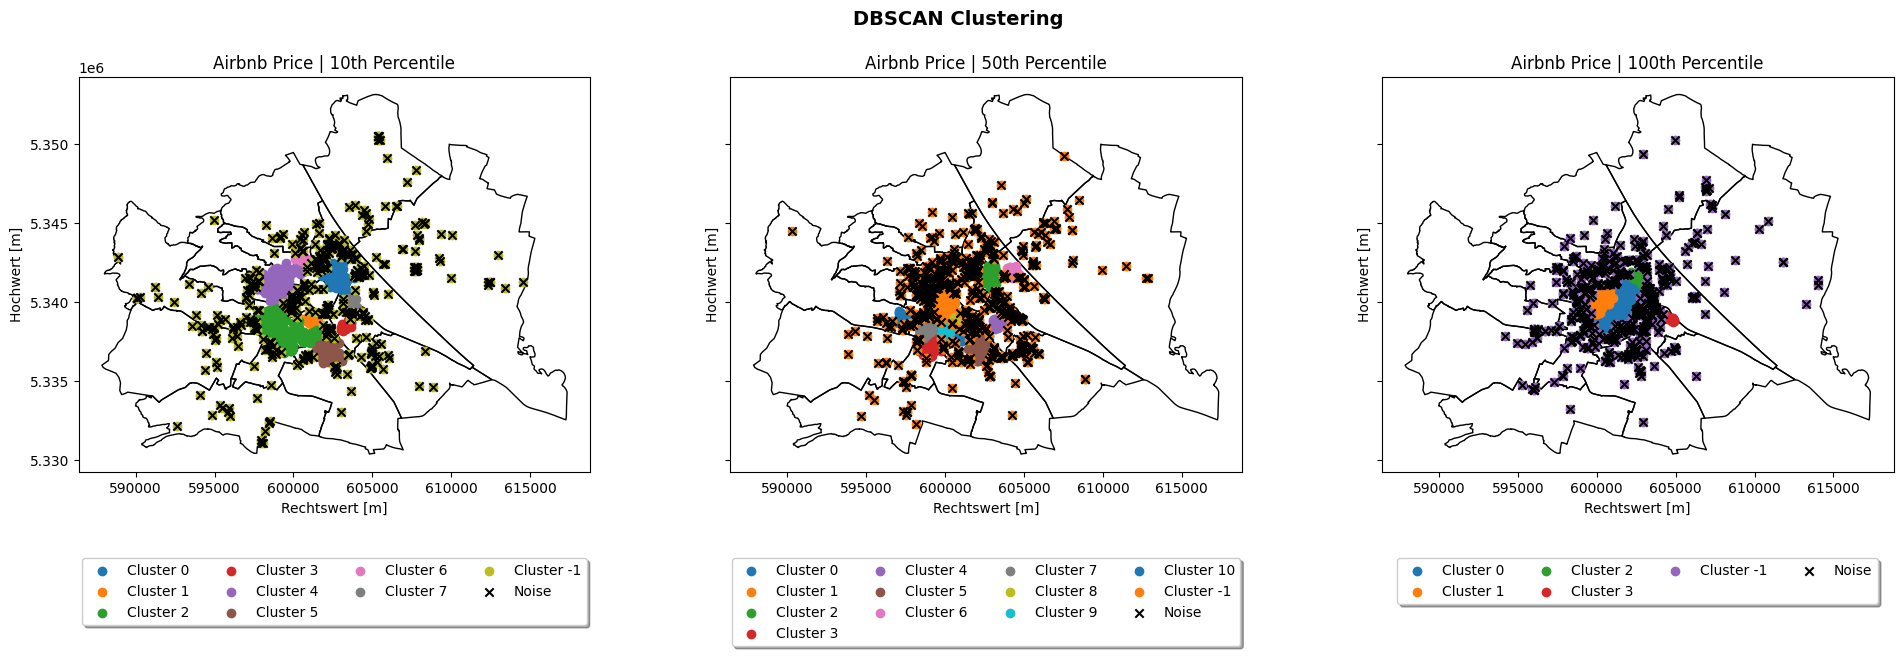

In [23]:
# ------------------------------------------------------------------------------
# DBSCAN clustering | plots
# ------------------------------------------------------------------------------

# Create list with input datasets
input_data_list = [airbnb_q_10_sel, airbnb_q_50_sel, airbnb_q_100_sel]

# Create subplots with a shared x and y axis
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# Loop over the input_data_list and create plots
for i, input_data in enumerate(input_data_list):

    # Standardize data
    scaler = sklearn.preprocessing.StandardScaler()
    df_scaled = scaler.fit_transform(input_data[['y', 'x']])

    # Create a DBSCAN model with the eps value calculated before
    dbscan = sklearn.cluster.DBSCAN(eps = 0.17, min_samples = 20)

    # Fit the model and get cluster labels
    cluster_labels = dbscan.fit_predict(df_scaled)

    # Add the cluster labels to the data frame
    input_data['cluster'] = cluster_labels

    # Plot district boundaries
    districts_proj_32633.plot(ax=axs[i], color='none', edgecolor='black')

    # Plot clustered data for each subplot
    axs[i].set_title(f'{title[i]}')
    axs[i].set_xlabel('Rechtswert [m]')
    axs[i].set_ylabel('Hochwert [m]')

    # Plot points for each cluster
    for cluster_label in set(input_data['cluster']):
        cluster_points = input_data[input_data['cluster'] == cluster_label]
        axs[i].scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster_label}')

    # Highlight noise points if any
    noise_points = input_data[input_data['cluster'] == -1]
    if not noise_points.empty:
        axs[i].scatter(noise_points['x'], noise_points['y'], color='black', marker='x', label='Noise')

    # Add legend
    axs[i].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', fancybox=True, shadow=True, ncol=4)

plt.suptitle('DBSCAN Clustering', fontsize=14, fontweight = 'bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<ipython-input-24-d0a5f0686e60>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['cluster'] = cluster_labels
<ipython-input-24-d0a5f0686e60>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['cluster'] = cluster_labels
<ipython-input-24-d0a5f0686e60>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

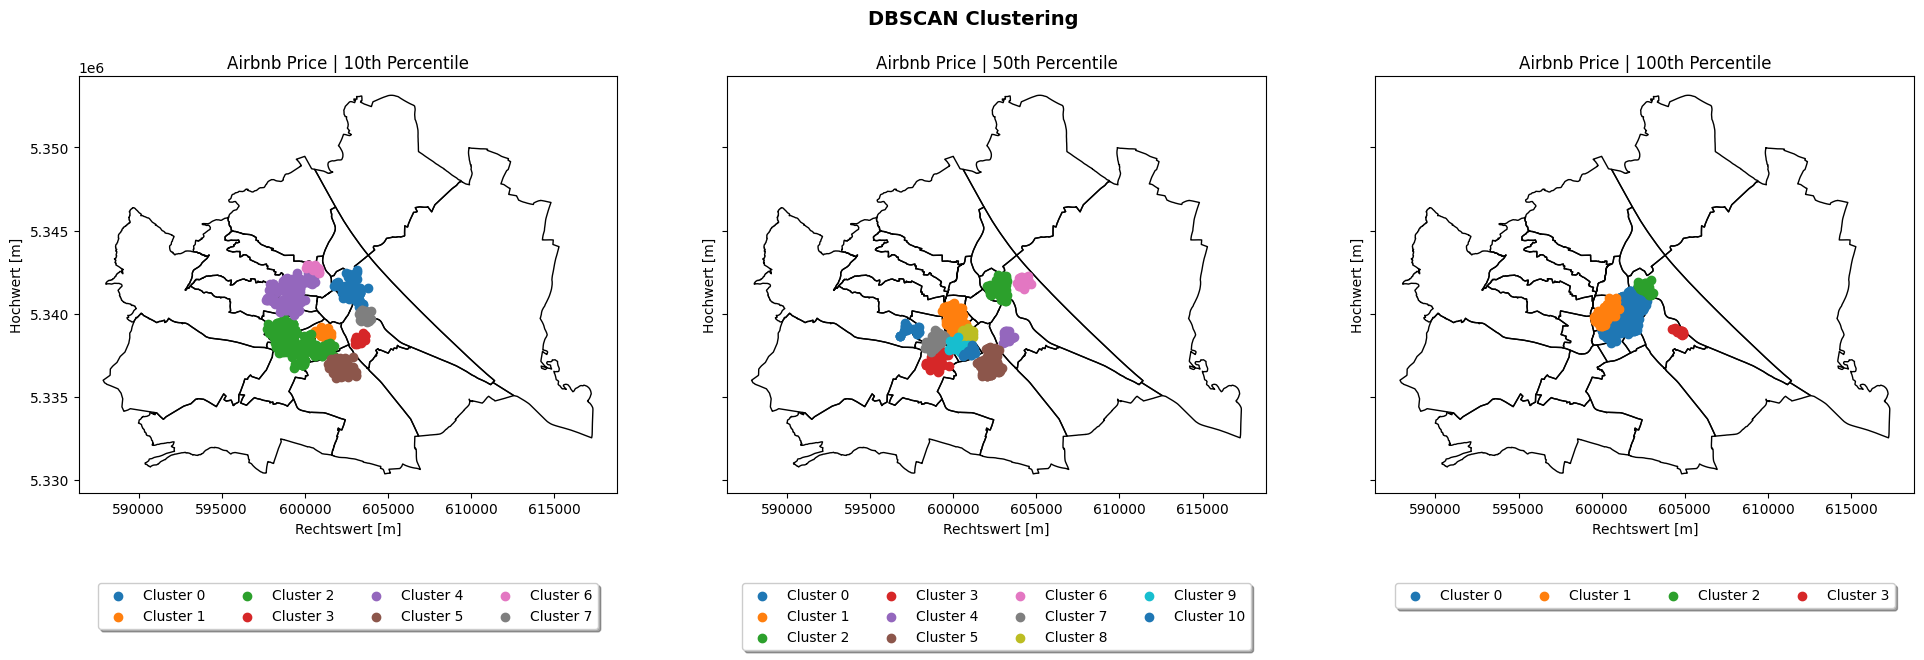

In [24]:
# ------------------------------------------------------------------------------
# DBSCAN clustering | plots excluding noise (cluster -1)
# ------------------------------------------------------------------------------

# Create 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# Iterate over input_data_list
for i, input_data in enumerate(input_data_list):

    # Standardize data
    scaler = sklearn.preprocessing.StandardScaler()
    df_scaled = scaler.fit_transform(input_data[['y', 'x']])

    # Create a DBSCAN model with eps = 0.17 and min_samples = 20
    dbscan = sklearn.cluster.DBSCAN(eps = 0.17, min_samples = 20)

    # Fit the model and get cluster labels
    cluster_labels = dbscan.fit_predict(df_scaled)

    # Add the cluster labels to the data frame
    input_data['cluster'] = cluster_labels

    # Plot district boundaries
    districts_proj_32633.plot(ax=axs[i], color='none', edgecolor='black')

    # Plot clustered data for each subplot
    axs[i].set_title(f'{title[i]}')
    axs[i].set_xlabel('Rechtswert [m]')
    axs[i].set_ylabel('Hochwert [m]')

    # Plot points for each cluster excluding cluster_label == -1
    for cluster_label in set(input_data['cluster']):
        if cluster_label != -1:
            cluster_points = input_data[input_data['cluster'] == cluster_label]
            axs[i].scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster_label}')

    # Add legend
    axs[i].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', fancybox=True, shadow=True, ncol=4)

# Set title
plt.suptitle('DBSCAN Clustering', fontsize=14, fontweight = 'bold')

# Plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [25]:
# ------------------------------------------------------------------------------
# Extract clusters from dataset
# ------------------------------------------------------------------------------

# Get unique clusters (q_10_clusters)
q_10_clusters = airbnb_q_10_sel['cluster'].unique()

# Write clusters into list (q_10_clusters)
list_q_10_clusters = []
for item in q_10_clusters:
  list_q_10_clusters.append(item)

# Sort list and remove cluster == -1 (q_10_clusters)
list_q_10_clusters.sort()
list_q_10_clusters.remove(-1)


# Get unique clusters (q_50_clusters)
q_50_clusters = airbnb_q_50_sel['cluster'].unique()

# Write clusters into list (q_50_clusters)
list_q_50_clusters = []
for item in q_50_clusters:
  list_q_50_clusters.append(item)

# Sort list and remove cluster == -1 (q_50_clusters)
list_q_50_clusters.sort()
list_q_50_clusters.remove(-1)


# Get unique clusters (q_100_clusters)
q_100_clusters = airbnb_q_100_sel['cluster'].unique()

# Write clusters into list (q_100_clusters)
list_q_100_clusters = []
for item in q_100_clusters:
  list_q_100_clusters.append(item)

# Sort list and remove cluster == -1 (q_100_clusters)
list_q_100_clusters.sort()
list_q_100_clusters.remove(-1)


# Print lists with clusters
print(list_q_10_clusters)
print(list_q_50_clusters)
print(list_q_100_clusters)

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 3]


In [26]:
# ------------------------------------------------------------------------------
# Function to process cluster data | SDS methods
# - Extract x/y
# - Create convex hulls
# - Create polygons from hulls
# - Calculate centroid of polygons
# - Calculate distances from centroids to Vienna center
# ------------------------------------------------------------------------------

# Create function taking a list of clusers, a data frame and a quantile number as input
def process_cluster(list_cluster, df, quantile):

  # Extract points of each cluster into its own data frame
  dist_to_center = []
  vienna_center = Point(601968.619, 5340368.99)

  list_name = f'list_polygons_q_{quantile}'
  globals()[list_name] = []

  for cluster in list_cluster:
    cluster_extract = f'q_{quantile}_cluster_{cluster}'
    globals()[cluster_extract] = df[df['cluster']==cluster]

    # Extract x and y
    point_extract = f'q_{quantile}_cluster_{cluster}_points'
    globals()[point_extract] = globals()[cluster_extract][['x', 'y']].values

    # Extract hulls
    hull_extract = f'q_{quantile}_cluster_{cluster}_hull'
    globals()[hull_extract] = scipy.spatial.ConvexHull(globals()[point_extract])

    # Transform hull into polygon object
    polygon_extract = f'q_{quantile}_cluster_{cluster}_polygon'
    globals()[polygon_extract] = Polygon(globals()[point_extract][globals()[hull_extract].vertices])

    globals()[list_name].append(globals()[polygon_extract])

    # Calculate centroid of polygon
    centroid_extract = f'q_{quantile}_cluster_{cluster}_centroid'
    globals()[centroid_extract] = globals()[polygon_extract].centroid

    # Calculate distance
    vienna_center.distance(globals()[centroid_extract])
    dist_to_center.append(vienna_center.distance(globals()[centroid_extract]))

  # Calculate mean distance to center
  mean_distance = round((sum(dist_to_center)/len(dist_to_center)/1000), 2)
  print(f'The mean distance of all clusters from quantile {quantile} to the center is: {mean_distance} km.')

  # Create multipolygon from polygons
  multipolygon_name = f'multipolygon_q_{quantile}'
  globals()[multipolygon_name] = shapely.MultiPolygon(globals()[list_name])

In [27]:
# ------------------------------------------------------------------------------
# Execute function for quantiles | SDS method
# ------------------------------------------------------------------------------

# Request function to calculate mean distance to center for each quantile
process_cluster(list_q_10_clusters,airbnb_q_10_sel, 10)
process_cluster(list_q_50_clusters,airbnb_q_50_sel, 50)
process_cluster(list_q_100_clusters,airbnb_q_100_sel, 100)

The mean distance of all clusters from quantile 10 to the center is: 2.48 km.
The mean distance of all clusters from quantile 50 to the center is: 2.92 km.
The mean distance of all clusters from quantile 100 to the center is: 1.72 km.


In [28]:
# ------------------------------------------------------------------------------
# Polygon objects to geo data frame
# ------------------------------------------------------------------------------

# Get polygons and transform into gdf (10th quantile)
polygon_q_10 = gpd.GeoDataFrame(geometry=[multipolygon_q_10])
polygon_q_10 = polygon_q_10.set_crs('epsg:32633')
polygon_q_10 = polygon_q_10.to_crs({'init':'epsg:4326'})
geojson_path = f'/content/drive/MyDrive/SDS/Output/polygon_q_10.geojson'
polygon_q_10.to_file(geojson_path, driver="GeoJSON")

# Get polygons and transform into gdf (50th quantile)
polygon_q_50 = gpd.GeoDataFrame(geometry=[multipolygon_q_50])
polygon_q_50 = polygon_q_50.set_crs('epsg:32633')
polygon_q_50 = polygon_q_50.to_crs({'init':'epsg:4326'})
geojson_path = f'/content/drive/MyDrive/SDS/Output/polygon_q_50.geojson'
polygon_q_50.to_file(geojson_path, driver="GeoJSON")

# Get polygons and transform into gdf (100th quantile)
polygon_q_100 = gpd.GeoDataFrame(geometry=[multipolygon_q_100])
polygon_q_100 = polygon_q_100.set_crs('epsg:32633')
polygon_q_100 = polygon_q_100.to_crs({'init':'epsg:4326'})
geojson_path = f'/content/drive/MyDrive/SDS/Output/polygon_q_100.geojson'
polygon_q_100.to_file(geojson_path, driver="GeoJSON")

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of 

In [29]:
# ------------------------------------------------------------------------------
# Create map to display results
# ------------------------------------------------------------------------------

# Create folium map
Vienna_Map = folium.Map([48.2083, 16.3731], zoom_start=11, tiles = 'cartodbpositron')

# Add district boundaries
folium.GeoJson(data=districts_proj_4326['geometry'], name = 'District Boundaries', style_function=lambda feature: {
        'fillColor': 'black',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.0
    }).add_to(Vienna_Map)

# Add and style polygons (10th quantile)
folium.GeoJson(data=polygon_q_10['geometry'], name = 'Cluster Hull 10th Quantile', style_function=lambda feature: {
        'fillColor': '#d9ed92',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.75
    }).add_to(Vienna_Map)

# Add and style polygons (50th quantile)
folium.GeoJson(data=polygon_q_50['geometry'], name = 'Cluster Hull 50th Quantile', style_function=lambda feature: {
        'fillColor': '#52b69a',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.75
    }).add_to(Vienna_Map)

# Add and style polygons (100th quantile)
folium.GeoJson(data=polygon_q_100['geometry'], name = 'Cluster Hull 100th Quantile', style_function=lambda feature: {
        'fillColor': '#184e77',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.75
    }).add_to(Vienna_Map)

# Add Vienna center point
folium.Circle(location=[48.2083, 16.3731], radius = 50, fill_color = 'white', color='white', fillOpacity = 1).add_to(Vienna_Map)

# Add basemap
folium.TileLayer('cartodbpositron', name = 'Basemap').add_to(Vienna_Map)

# Add legend
folium.LayerControl().add_to(Vienna_Map)

# Plot map
Vienna_Map